In [1]:
%%bash
# preamble script to check and install AMUSE components if necessary

# required packages for this tutorial:
PACKAGES="amuse-framework amuse-kepler"
# skip in case a full development install is present
pip show amuse-devel && exit 0
for package in ${PACKAGES} 
do
  pip show ${package} || pip install ${package}
done


Name: amuse-devel
Version: 2024.6.1.dev9+gecb3db99e
Summary: The Astrophysical Multipurpose Software Environment
Home-page: http://www.amusecode.org/
Author: The AMUSE team
Author-email: info@amusecode.org
License: Apache License 2.0
Location: /data2/pouw/miniforge3/envs/Amuse-env/lib/python3.12/site-packages
Editable project location: /data2/pouw/amuse-src
Requires: docutils, h5py, numpy, pip, pytest, setuptools, setuptools-scm, wheel
Required-by: 


In [2]:
# the following fixes are highly recommended

#allow oversubscription for openMPI
import os
os.environ["OMPI_MCA_rmaps_base_oversubscribe"]="true"

# use lower cpu resources for idle codes
from amuse.support import options
options.GlobalOptions.instance().override_value_for_option("polling_interval_in_milliseconds", 10)


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from amuse.units import units, constants
from amuse.lab import Particles, Particle
from amuse.ext.orbital_elements import generate_binaries, orbital_elements

from amuse.community.huayno.interface import Huayno
from amuse.units import nbody_system
from amuse.ext.LagrangianRadii import LagrangianRadii

import matplotlib.pyplot as plt

# We define some properties for the figures
import matplotlib as mpl
SMALL_SIZE = 10 * 2 
MEDIUM_SIZE = 12 * 2
BIGGER_SIZE = 14 * 2

plt.rc('text', usetex=True)
plt.rc('axes', titlesize=SMALL_SIZE)                     # fontsize of the axes title\n",
plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=SMALL_SIZE, direction='out')   # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=SMALL_SIZE, direction='out')   # fontsize of the tick labels\n",
plt.rc('legend', fontsize=SMALL_SIZE)                    # legend fontsize\n",
mpl.rcParams['axes.titlesize'] = BIGGER_SIZE
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'STIXgeneral'

mpl.rcParams['figure.dpi'] = 100

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['ytick.minor.size'] = 4

mpl.rcParams['xtick.major.width'] = 1.25
mpl.rcParams['ytick.major.width'] = 1.25
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1

In [4]:
SMBH_ORBITAL_RADIUS = 44 * 1e-3 | units.parsec
SMBH_ECCENTRICITY = 0.32

PRIMARY_MASS = 2.8 | units.MSun
SECONDARY_MASS = 0.73 | units.MSun

BINARY_SEPARATION = 1.59 | units.AU
BINARY_INCLINATION = 102.55 | units.deg
BINARY_ECCENTRICITY = 0.45
BINARY_PERIAPSE = 311.75 | units.deg


SMBH_MASS = 4.297e6 | units.MSun


def orbital_period(mass, radius):
    return np.sqrt(radius.value_in(units.AU)**3 / mass.value_in(units.MSun)) | units.yr


smbh_binary_period = orbital_period(SMBH_MASS, SMBH_ORBITAL_RADIUS)
binary_period = orbital_period(PRIMARY_MASS + SECONDARY_MASS, BINARY_SEPARATION)
kozai_timescale = smbh_binary_period**2 / binary_period
print(smbh_binary_period, binary_period)
print(kozai_timescale.value_in(units.yr))


417.094091419 yr 1.06710789682 yr
163027.076845


In [5]:
help(generate_binaries)

Help on function generate_binaries in module amuse.ext.orbital_elements:

generate_binaries(primary_mass, secondary_mass, semi_major_axis, eccentricity=0, true_anomaly=quantity<0 rad>, inclination=quantity<0 rad>, longitude_of_the_ascending_node=quantity<0 rad>, argument_of_periapsis=quantity<0 rad>, G=None)
    returns two particlesets, which contain the primaries and the secondaries
    in binary pairs.



In [91]:
smbh_and_binary = Particles(1)
smbh = smbh_and_binary[0]
smbh.mass = SMBH_MASS
smbh.position = (0, 0, 0) | units.km
smbh.velocity = (0, 0, 0) | units.km / units.s

primary, secondary = generate_binaries(PRIMARY_MASS, 
                                        SECONDARY_MASS, 
                                        BINARY_SEPARATION, 
                                        eccentricity=BINARY_ECCENTRICITY, 
                                        true_anomaly=np.random.uniform(low=0, high=2 * np.pi) | units.rad, 
                                        inclination=BINARY_INCLINATION,
                                        argument_of_periapsis=BINARY_PERIAPSE)
binary_com_velocity = (constants.G * smbh.mass / SMBH_ORBITAL_RADIUS).sqrt()

primary.position += (1, 0, 0) * SMBH_ORBITAL_RADIUS
secondary.position += (1, 0, 0) * SMBH_ORBITAL_RADIUS

primary.velocity += (0, 1, 0) * binary_com_velocity
secondary.velocity += (0, 1, 0) * binary_com_velocity

smbh_and_binary.add_particle(primary)
smbh_and_binary.add_particle(secondary)

smbh_and_binary.move_to_center()

print(smbh_and_binary)


                 key         mass           vx           vy           vz            x            y            z
                   -         MSun       km / s       km / s       km / s           km           km           km
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========
 7504846163692814588    4.297e+06   -8.268e-22   -5.325e-04    1.033e-22   -1.115e+06    0.000e+00    0.000e+00
 6106008901812783551    2.800e+00    6.569e+00    6.483e+02   -7.680e-01    1.358e+12    1.371e+07   -6.161e+07
 7306423601240457907    7.300e-01   -2.519e+01    6.475e+02    2.946e+00    1.358e+12   -5.260e+07    2.363e+08
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========


                 key         mass           vx           vy           vz            x            y            z
                   -         MSun       km / s       km / s       km / s           km           km           km
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========
 7504846163692814588    4.297e+06   -8.268e-22   -5.325e-04    1.033e-22   -1.115e+06    0.000e+00    0.000e+00
 6106008901812783551    2.800e+00    6.569e+00    6.483e+02   -7.680e-01    1.358e+12    1.371e+07   -6.161e+07
 7306423601240457907    7.300e-01   -2.519e+01    6.475e+02    2.946e+00    1.358e+12   -5.260e+07    2.363e+08
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========


(-13613.477212201702, 13613.477212201702)

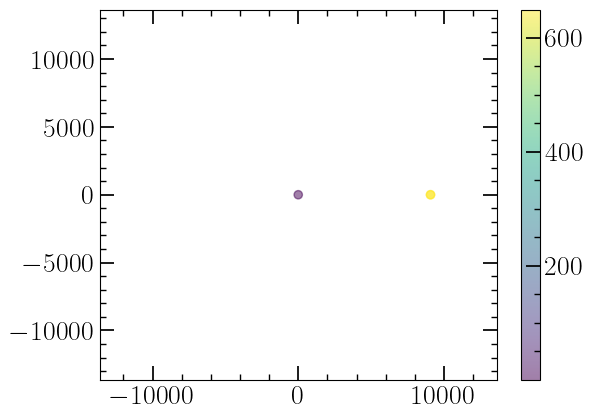

In [92]:
print(smbh_and_binary)

v = (smbh_and_binary.vx**2 + smbh_and_binary.vy**2 + smbh_and_binary.vz**2).sqrt()
plt.scatter(smbh_and_binary.x.value_in(units.AU), smbh_and_binary.y.value_in(units.AU), c=v.value_in(units.kms), alpha=0.5)
plt.colorbar()
plt.xlim(-1.5 * SMBH_ORBITAL_RADIUS.value_in(units.AU), 1.5 * SMBH_ORBITAL_RADIUS.value_in(units.AU))
plt.ylim(-1.5 * BINARY_ORBITAL_RADIUS.value_in(units.AU), 1.5 * BINARY_ORBITAL_RADIUS.value_in(units.AU))

In [93]:
print(smbh_and_binary)

                 key         mass           vx           vy           vz            x            y            z
                   -         MSun       km / s       km / s       km / s           km           km           km
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========
 7504846163692814588    4.297e+06   -8.268e-22   -5.325e-04    1.033e-22   -1.115e+06    0.000e+00    0.000e+00
 6106008901812783551    2.800e+00    6.569e+00    6.483e+02   -7.680e-01    1.358e+12    1.371e+07   -6.161e+07
 7306423601240457907    7.300e-01   -2.519e+01    6.475e+02    2.946e+00    1.358e+12   -5.260e+07    2.363e+08
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========


In [95]:
converter = nbody_system.nbody_to_si(smbh_and_binary.mass.sum(), BINARY_ORBITAL_RADIUS)

gravity = Huayno(converter)
gravity.particles.add_particles(smbh_and_binary)
gravity.set_integrator('OK')

channel = gravity.particles.new_channel_to(smbh_and_binary)

start_time = 0  # yr
end_time = 5e5  # yr
stepsize = 200  # yr
times = np.arange(start_time, end_time, stepsize) | units.yr
eccentricities = []
inclinations = [] | units.deg
semimajors = [] | units.AU
for i, time in enumerate(times):

    gravity.evolve_model(time)
    channel.copy()
    
    binary = smbh_and_binary[1:]
    _, _, axs, ecc, _, inc, _, _  = orbital_elements(binary, G=constants.G)  # mass1, mass2, semimajor_axis, eccentricity, true_anomaly.value_in(units.deg), inclination.value_in(units.deg), long_asc_node.value_in(units.deg), arg_per.value_in(units.deg))
    eccentricities.append(ecc)
    inclinations.append(inc)
    semimajors.append(axs)

    if not i % 100:
        print(time)

gravity.stop()


0.0 yr
20000.0 yr
40000.0 yr
60000.0 yr
80000.0 yr
100000.0 yr
120000.0 yr
140000.0 yr
160000.0 yr
180000.0 yr
200000.0 yr
220000.0 yr
240000.0 yr
260000.0 yr
280000.0 yr
300000.0 yr
320000.0 yr
340000.0 yr
360000.0 yr
380000.0 yr
400000.0 yr
420000.0 yr
440000.0 yr
460000.0 yr
480000.0 yr


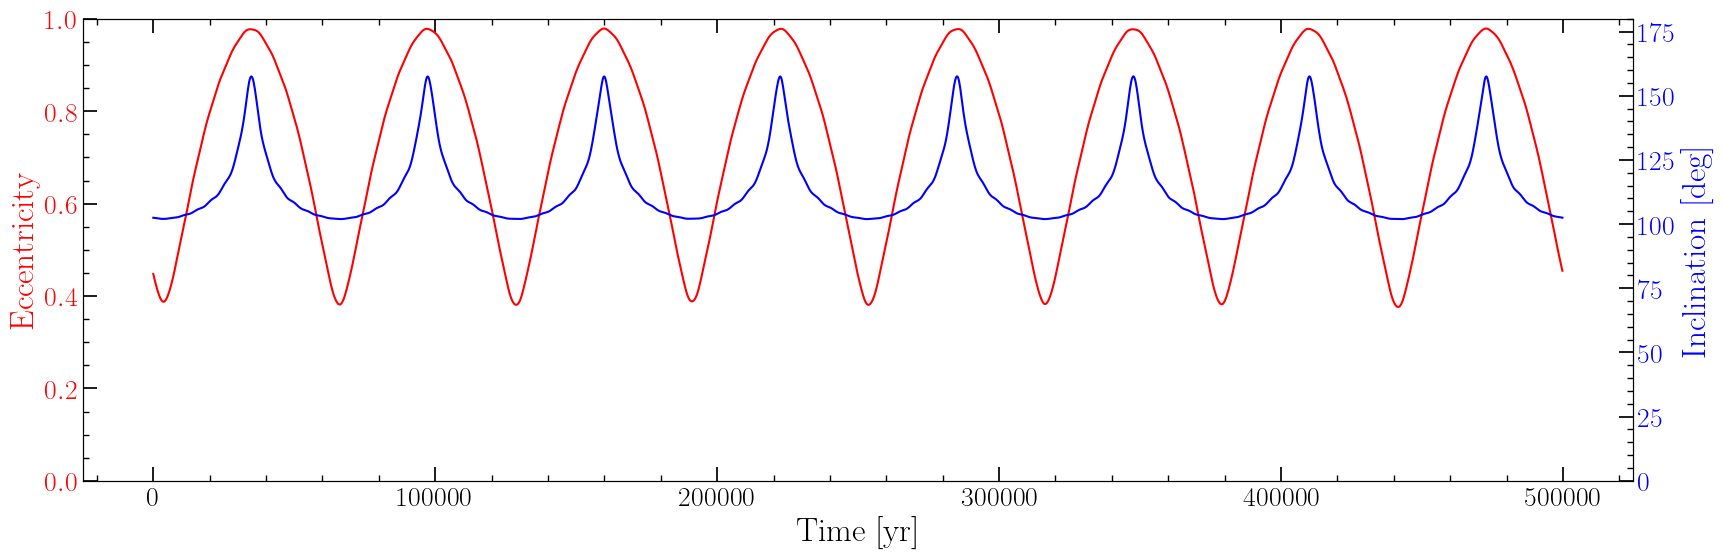

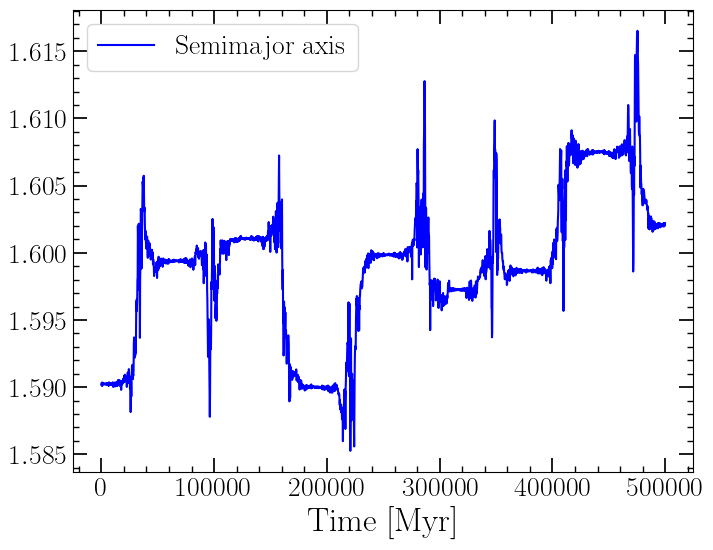

In [96]:
fig, ax1 = plt.subplots(figsize=(20,6))
ax2 = ax1.twinx()

ax1.plot(times.value_in(units.yr), np.array(eccentricities), color='red', label='Eccentricity')
plt.plot(times.value_in(units.yr), inclinations.value_in(units.deg), color='blue', label='Inclination')

ax1.set_xlabel('Time [yr]')
ax1.set_ylabel('Eccentricity', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_ylim(0,1)

ax2.set_ylabel('Inclination [deg]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 180)

plt.show()

plt.figure(figsize=(8,6))
plt.plot(times.value_in(units.yr), semimajors.value_in(units.AU), color='blue', label='Semimajor axis')
plt.xlabel('Time [Myr]')
plt.legend()
plt.show()


In [97]:
# print(binary)
orbital_elements(binary)

(quantity<2.8 MSun>,
 quantity<0.73 MSun>,
 quantity<239682458.074 1000.0 * m>,
 0.45473690717456872,
 quantity<2.71252171964 rad>,
 quantity<1.78929817118 rad>,
 quantity<-0.0216961034415 rad>,
 quantity<-0.804030334605 rad>)

[  1.60000000e-05   3.20000000e-05   4.80000000e-05]


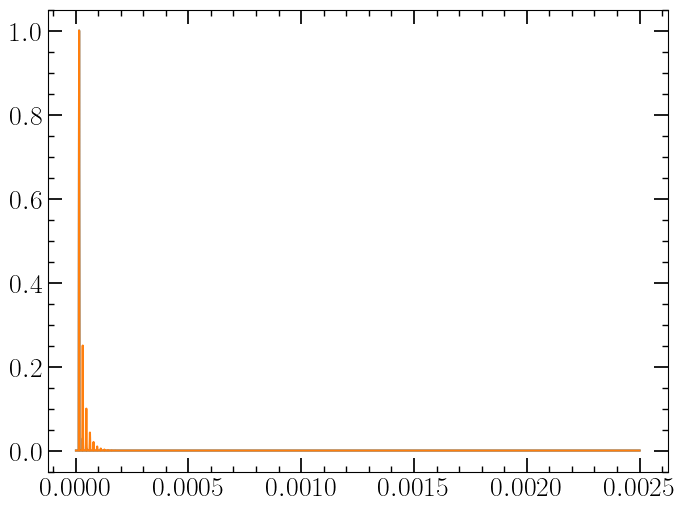

[  1.60000000e-05   3.20000000e-05   4.80000000e-05   6.40000000e-05
   8.00000000e-05   9.60000000e-05   1.12000000e-04   1.28000000e-04
   1.44000000e-04   1.60000000e-04]


In [100]:
from scipy.signal import periodogram, find_peaks

freq, strength = periodogram(eccentricities, fs=1/stepsize)

plt.figure(figsize=(8,6))
plt.plot(freq[1:], strength[1:] / np.max(strength[1:]))
# plt.xlim(0, 0.05)
# plt.semilogy()

print(freq[list(reversed(np.argsort(strength)))][:3])

freq, strength = periodogram(inclinations.number, fs=1/stepsize)

plt.plot(freq[1:], strength[1:] / np.max(strength[1:]))
# plt.xlim(0, 0.025)
plt.show()

print(freq[list(reversed(np.argsort(strength)))][:10])
